In [3]:
!pip install -e ../Maccabee

Obtaining file:///home/jovyan/work/Maccabee
  Found existing installation: maccabee 0.0.12
    Uninstalling maccabee-0.0.12:
      Successfully uninstalled maccabee-0.0.12
  Running setup.py develop for maccabee


In [1]:
from maccabee.data_analysis import calculate_data_axis_metrics, gather_axis_metrics_for_given_params
from maccabee.constants import Constants
import maccabee.data_sources as data_sources
from maccabee.parameters import build_default_parameters, build_parameters_from_axis_levels

from maccabee.data_generation import SampledDataGeneratingProcess, data_generating_method

# benchmarks
from maccabee.benchmarking import benchmark_model_using_concrete_dgp
from maccabee.benchmarking import benchmark_model_using_sampled_dgp
from maccabee.benchmarking import benchmark_model_using_sampled_dgp_grid

# genmatch
from maccabee.examples.genmatch import GenmatchDataGeneratingProcess, build_genmatch_datasource, GENMATCH_SPECS
from maccabee.examples.genmatch import LogisticPropensityMatchingCausalModel

In [2]:
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
BASE_GENMATCH_DGP_PARAMS = {
  "OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7,
        "POLY_QUAD": 0,
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0,
        "INTERACTION_THREE_WAY": 0,
  },
  "TREATMENT_EFFECT_HETEROGENEITY": 0,
  "ACTUAL_CONFOUNDER_ALIGNMENT": 0,
  "MIN_PROPENSITY_SCORE": 0.1,
  "MAX_PROPENSITY_SCORE": 0.9,
  "OUTCOME_NOISE_TAIL_THICKNESS": 1000,
  "SUBFUNCTION_CONSTANT_TAIL_THICKNESS": 1000,
  "TREATMENT_EFFECT_TAIL_THICKNESS": 1000
}

A_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
A_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.0,
    "INTERACTION_THREE_WAY": 0,
}
  
C_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
C_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.3,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.0,
    "INTERACTION_THREE_WAY": 0,
}

G_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
G_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.3,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.11,
    "INTERACTION_THREE_WAY": 0,
}

X_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
X_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.99,
    "POLY_CUBIC": 0.99,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.99,
    "INTERACTION_THREE_WAY": 0,
}

## Param Validation

In [4]:
# Define axes and metrics to analyze
axes_and_metrics = {
    Constants.AxisNames.OUTCOME_NONLINEARITY: [
        "Lin r2(X_obs, Y)",
        "Lin r2(X_true, Y)"
    ],
    Constants.AxisNames.TREATMENT_NONLINEARITY: [
        "Lin r2(X_obs, Treat Logit)"
    ],
    Constants.AxisNames.PERCENT_TREATED: [
        "Percent(T==1)"
    ],
    Constants.AxisNames.BALANCE: [
        "Wass dist X_true: T=1<->T=0",
    ],
    Constants.AxisNames.ALIGNMENT: [
        "Lin r2(Y, Treat Logit)",
        "Lin r2(Y0, Treat Logit)"
    ],
    Constants.AxisNames.TE_HETEROGENEITY: [
        "std(TE)/std(Y)"
    ]
}

In [9]:
%%time

genmatch_dgp = GenmatchDataGeneratingProcess(
        *GENMATCH_SPECS["G"],
        n_observations=1000, analysis_mode=True)

n_genmatch_samples = 1

# TODO: it should be possible to get metric vals from multiple draws from a DGP
# and also to get metric vals from a parameterization of a DGP sampler.
# This code can then be replaced.
genmatch_metric_vals = defaultdict(lambda: defaultdict(list))
for _ in range(n_genmatch_samples):
    genmatch_dataset = genmatch_dgp.generate_dataset()
    metrics = calculate_data_axis_metrics(genmatch_dataset, axes_and_metrics)
    print(metrics)
    for metric, measures in axes_and_metrics.items():
        for measure in measures:
            res = metrics[metric][measure]
            if res is not None:
                genmatch_metric_vals[metric][measure].append(res)

{'OUTCOME_NONLINEARITY': {'Lin r2(X_obs, Y)': 0.9717970032085838, 'Lin r2(X_true, Y)': 0.9734139471710932}, 'TREATMENT_NONLINEARITY': {'Lin r2(X_obs, Treat Logit)': 0.7953566420430647}, 'PERCENT_TREATED': {'Percent(T==1)': 45.3}, 'BALANCE': {'Wass dist X_true: T=1<->T=0': 0.05301391334299869}, 'ALIGNMENT': {'Lin r2(Y, Treat Logit)': 0.019831223327815395, 'Lin r2(Y0, Treat Logit)': 0.001172167811176239}, 'TE_HETEROGENEITY': {'std(TE)/std(Y)': 5.4871745066820603e-17}}
CPU times: user 465 ms, sys: 265 ms, total: 730 ms
Wall time: 313 ms


In [6]:
%%time

n_mc_samples = 10

dgp_params = build_default_parameters()
dgp_params.set_parameters(G_param_overrides)

genmatch_datasource = build_genmatch_datasource()

mc_metric_vals = gather_axis_metrics_for_given_params(
    dgp_params, axes_and_metrics, genmatch_datasource, n_trials=n_mc_samples)

-0.336221390307282*X0 + 0.307519564305441*X2 - 0.158543419819694*X5 + 0.773582548430577*X6 + 0.602738346038665*X8 - 0.46196272326773*X9 + 0.106078344094658 1.024
0.267070203853359*X0 + 0.10415737950281*X1 - 0.432653730242442*X2 - 0.0640968489248062*X3 - 0.349861967047901*X4 - 0.00267070203853359*X5 + 0.779844995251809*X6 - 0.149559314157881*X7 - 0.283080921885676 0.411
0.226671160601359*X0 + 0.669219617013535*X1 - 0.116573739737842*X10 - 0.658425752222994*X2 - 0.0777158264918944*X3 - 0.060445642827029*X6 + 0.328133489632443*X7 - 0.194289566229736*X8 - 0.122827583134848 1.067
-0.260998036581946*X0 + 0.411269633401855*X10 + 0.483769088007951*X2 + 0.374360820147842*X3 - 0.746085296491826*X4 - 0.260998036581946*X6 + 0.222231372756849 2.211
-0.155500420897468*X0 - 0.56872839124537*X1 + 0.23613026877023*X10 + 0.622001683589873*X3 + 0.174218064153645*X4 + 0.0014398187120136*X5 - 0.188616251273781*X6 + 0.264926643010502*X7 - 0.207333894529958*X8 + 0.371473227699508*X9 + 0.290365529053823 1.326

In [8]:
for axes, metrics in axes_and_metrics.items():
    print(axes)
    for metric in metrics:
        print("\t", metric)
        print("\t\tGenmatch:", np.round(np.mean(genmatch_metric_vals[axes][metric]), 3))
        print("\t\tMC:", np.round(np.mean(mc_metric_vals[axes][metric]), 3))

OUTCOME_NONLINEARITY
	 Lin r2(X_obs, Y)
		Genmatch: 0.971
		MC: 0.716
	 Lin r2(X_true, Y)
		Genmatch: 0.969
		MC: 0.726
TREATMENT_NONLINEARITY
	 Lin r2(X_obs, Treat Logit)
		Genmatch: 0.789
		MC: 0.56
PERCENT_TREATED
	 Percent(T==1)
		Genmatch: 45.11
		MC: 50.11
BALANCE
	 Wass dist X_true: T=1<->T=0
		Genmatch: 0.053
		MC: 0.036
ALIGNMENT
	 Lin r2(Y, Treat Logit)
		Genmatch: 0.032
		MC: 0.062
	 Lin r2(Y0, Treat Logit)
		Genmatch: 0.006
		MC: 0.047
TE_HETEROGENEITY
	 std(TE)/std(Y)
		Genmatch: 0.0
		MC: 0.0


## Benchmarks

At config A, 20-50 matches across runs. Wide distro. Should investigate the stability of the concrete distro when n=1000.

At config G, 20-50 has much lower bias in the sampled benchmark. The concrete function appears to be a worst case scenario given that very similar functions experience much lower typical bias. The distribution is right tailed and so it is possible that the concrete func chosen is just an (un)lucky sample from right tail.

I will test this by permuting the variable order in the exact same functional form.

### Genmatch Concrete Benchmark

In [9]:
%%time

# Concrete Benchmark
dgp = GenmatchDataGeneratingProcess(
    *GENMATCH_SPECS["A"],
    n_observations=10000, analysis_mode=False)

genmatch_agg_results, genmatch_raw_results = benchmark_model_using_concrete_dgp(
    dgp=dgp,
    model_class=LogisticPropensityMatchingCausalModel,
    estimand=Constants.Model.ATE_ESTIMAND,
    n_jobs=7,
    num_runs=15,
    num_samples_from_dgp=30)

3 (-0.43880775768254676, -0.40000000000000013)
4 (-0.4395243486113022, -0.40000000000000013)
5 (-0.3943781513487502, -0.40000000000000013)
1 (-0.40426747327268386, -0.40000000000000013)
0 (-0.4167297898183082, -0.40000000000000013)
6 (-0.41784386764855286, -0.40000000000000013)
2 (-0.3806658176416681, -0.40000000000000013)
8 (-0.4045051445224187, -0.40000000000000013)
9 (-0.380809372217461, -0.40000000000000013)
7 (-0.3967386182972462, -0.40000000000000013)
11 (-0.40482757862817553, -0.40000000000000013)
12 (-0.446598013369345, -0.40000000000000013)
10 (-0.33613452317431075, -0.40000000000000013)
13 (-0.36744469922631917, -0.40000000000000013)
15 (-0.3925096142840467, -0.40000000000000013)
17 (-0.42713529309921355, -0.40000000000000013)
16 (-0.3346062176877898, -0.40000000000000013)
14 (-0.4161612721146791, -0.40000000000000013)
18 (-0.4308586031098442, -0.40000000000000013)
19 (-0.3889062457729327, -0.40000000000000013)
20 (-0.41186179459294114, -0.40000000000000013)
21 (-0.4262293308

26 (-0.4141315141724825, -0.40000000000000013)
27 (-0.37189058596180247, -0.40000000000000013)
28 (-0.43770181014312476, -0.40000000000000013)
29 (-0.3821641397582666, -0.40000000000000013)
2 (-0.3895949191157177, -0.40000000000000013)
3 (-0.38849270520957435, -0.40000000000000013)
0 (-0.3926128955075682, -0.40000000000000013)
4 (-0.409892221122141, -0.40000000000000013)
5 (-0.4113211062745426, -0.40000000000000013)
1 (-0.3890428629106293, -0.40000000000000013)
6 (-0.406197486672017, -0.40000000000000013)
7 (-0.4353880623702347, -0.40000000000000013)
12 (-0.4028006889517373, -0.40000000000000013)
9 (-0.43224022510153653, -0.40000000000000013)
13 (-0.4177319343694508, -0.40000000000000013)
8 (-0.4127294138953801, -0.40000000000000013)
10 (-0.362220953471704, -0.40000000000000013)
11 (-0.4170159559253313, -0.40000000000000013)
14 (-0.40571017610333704, -0.40000000000000013)
15 (-0.4270515065815444, -0.40000000000000013)
16 (-0.47775255732701216, -0.40000000000000013)
17 (-0.3254249115955

21 (-0.3837671439849936, -0.40000000000000013)
22 (-0.40549024573572906, -0.40000000000000013)
25 (-0.427205466371241, -0.40000000000000013)
24 (-0.39768159546835613, -0.40000000000000013)
26 (-0.3682563053692169, -0.40000000000000013)
23 (-0.38419451266243965, -0.40000000000000013)
27 (-0.3785915071078211, -0.40000000000000013)
28 (-0.38452919969232696, -0.40000000000000013)
29 (-0.4237226954792174, -0.40000000000000013)
0 (-0.36544818825136005, -0.40000000000000013)
3 (-0.38189955610091764, -0.40000000000000013)
2 (-0.4258659309130716, -0.40000000000000013)
5 (-0.39113348288739097, -0.40000000000000013)
6 (-0.38776443246159215, -0.40000000000000013)
1 (-0.39508425839964884, -0.40000000000000013)
4 (-0.4029605156473667, -0.40000000000000013)
9 (-0.3981637639296533, -0.40000000000000013)
7 (-0.4392261315884207, -0.40000000000000013)
8 (-0.37869651342978994, -0.40000000000000013)
13 (-0.3837303559297433, -0.40000000000000013)
12 (-0.4111799689636353, -0.40000000000000013)
11 (-0.4128874

In [10]:
genmatch_agg_results

{'absolute mean bias %': 0.723,
 'absolute mean bias % (std)': 0.477,
 'root mean squared error': 0.027,
 'root mean squared error (std)': 0.003}

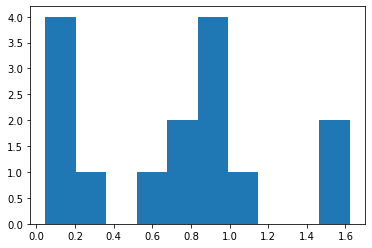

In [12]:
plt.hist(genmatch_raw_results["absolute mean bias %"])
plt.show()

### Sampled Benchmark

In [10]:
%%time

class NoiselessSampledDataGeneratingProcess(SampledDataGeneratingProcess):
    
    @data_generating_method(Constants.OUTCOME_NOISE_NAME, [])
    def _generate_outcome_noise_samples(self, input_vars):
        return 0
    
base_params = {
    Constants.AxisNames.TREATMENT_NONLINEARITY: Constants.AxisLevels.LOW,
    Constants.AxisNames.OUTCOME_NONLINEARITY: Constants.AxisLevels.LOW,
    Constants.AxisNames.TE_HETEROGENEITY: Constants.AxisLevels.LOW,
    Constants.AxisNames.ALIGNMENT: Constants.AxisLevels.LOW
}
dgp_params = build_parameters_from_axis_levels(base_params)
dgp_params.set_parameters(A_param_overrides)


mc_agg_result, mc_raw_results = benchmark_model_using_sampled_dgp(
    dgp_params, build_genmatch_datasource(),
    dgp_class=NoiselessSampledDataGeneratingProcess,
    model_class=LogisticPropensityMatchingCausalModel,
    estimand=Constants.Model.ATE_ESTIMAND,
    num_dgp_samples=5,
    num_samples_from_dgp=10,
    n_jobs=7,
    dgp_kwargs={"analysis_mode": False})

CPU times: user 210 ms, sys: 256 ms, total: 466 ms
Wall time: 6.18 s


In [11]:
mc_agg_result

{'absolute mean bias %': 1.889,
 'absolute mean bias % (std)': 0.0,
 'root mean squared error': 0.008,
 'root mean squared error (std)': 0.0}

In [13]:
mc_raw_results

defaultdict(list,
            {'absolute mean bias %': [1.889, 1.889, 1.889, 1.889, 1.889],
             'root mean squared error': [0.008, 0.008, 0.008, 0.008, 0.008]})

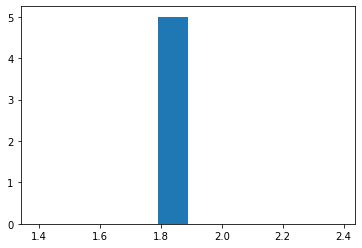

In [12]:
plt.hist(mc_raw_results["absolute mean bias %"])
plt.show()

In [9]:
a = np.empty((2, 2))
a[0, :] = (1, 2)
a

array([[1.0e+000, 2.0e+000],
       [9.9e-324, 1.5e-323]])